# 数据挖掘互评作业四：离群点分析与异常检测--pageb

## 1. 问题描述

本次作业将从Anomaly Detection Meta-Analysis Benchmarks提供的benchmark数据集中任选两个进行分析。

## 2. 数据来源--pageb

Anomaly Detection Meta-Analysis Benchmarks
借助使用Python Outlier Detection (PyOD)或其他已知的工具包来完成分析工作。

In [1]:
import os
import sys
from time import time

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
# supress warnings for clean output
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.pca import PCA

from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score

In [2]:
path = 'pageb/benchmarks'
csv_list = os.listdir(path)
df = pd.read_csv(os.path.join(path,csv_list[0]))
df.head()

,point.id,motherset,origin,original.label,diff.score,ground.truth,V,V.1,V.2,V.3,V.4,V.5,V.6,V.7,V.8,V.9
0,pageb_point_2739,pageb,multiclass,1,0.021586,nominal,-0.024959,-0.719726,-0.232691,-0.425159,-0.223015,1.177463,-0.064409,-0.269953,-0.357219,-0.559822
1,pageb_point_0048,pageb,multiclass,2,0.010946,anomaly,-0.446887,-0.588975,-0.238052,-0.089695,1.892235,0.462597,0.134349,-0.263656,-0.373695,-0.625569
2,pageb_point_0980,pageb,multiclass,1,0.026369,nominal,-0.183182,-0.379773,-0.180725,-0.233945,-0.363657,1.042693,-0.052683,-0.210914,-0.229130,-0.410397
3,pageb_point_0743,pageb,multiclass,2,0.005276,anomaly,-0.499628,-0.632559,-0.243620,0.105721,2.229775,1.259497,0.004064,-0.277825,-0.384856,-0.625569
4,pageb_point_1408,pageb,multiclass,1,0.030725,nominal,-0.024959,0.090931,-0.040914,-0.122264,-0.881218,-0.486652,-0.069041,-0.121174,-0.020786,0.235117


选取ground.truth	V	V.1	V.2	V.3	V.4	V.5	V.6	V.7	V.8	V.9作为特征输入

In [3]:
data_1 = pd.DataFrame()
for i in csv_list:
    df = pd.read_csv(os.path.join(path,i))
    data_1 = data_1.append(df[['V', 'V.1', 'V.2', 'V.3', 'V.4', 'V.5', 'V.6', 'V.7', 'V.8', 'V.9', 'ground.truth']])

划分训练集和测试集，选取60%做为训练集40%做测试集，并把ground.truth中的'anomaly'设为1 'nominal'设为0

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_1, test_size=0.4, random_state=42)

def change_label(data, label_column='ground.truth'):
    x = data.drop(label_column, axis=1)#取V-V.9平均值
    y = []
    for i in data[label_column].values:
        if i == 'anomaly':
            y.append(1)
        else:
            y.append(0)
    y = np.array(y)
    return x, y

X_train, y_train = change_label(train)
X_test, y_test = change_label(test)

利用pyod中的包，用不同的模型进行离群点分析

## KNN

In [5]:
# train the KNN detector
from pyod.models.knn import KNN

clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores


In [6]:
from pyod.utils.data import evaluate_print
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
KNN ROC:0.8205, precision @ rank n:0.4944

On Test Data:
KNN ROC:0.7909, precision @ rank n:0.4949


## 可视化
利用TSNE对高维数据进行降维处理

In [7]:
from sklearn.manifold import TSNE
# T-SNE Implementation
X_train_tsne = TSNE(n_components=2, random_state=2000, init='pca', n_iter=2000).fit_transform(X_train.values)
X_test_tsne = TSNE(n_components=2, random_state=2000, init='pca', n_iter=2000).fit_transform(X_test.values)

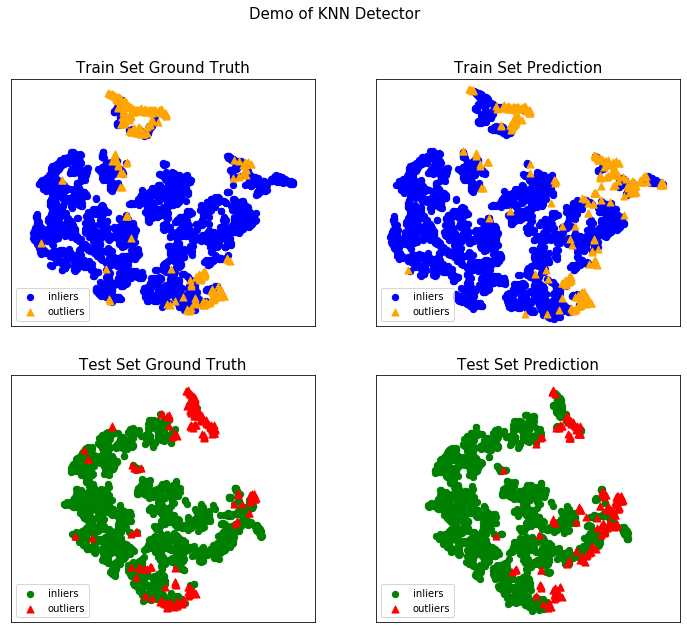

In [8]:
from pyod.utils.example import visualize
visualize(clf_name, X_train_tsne, y_train, X_test_tsne, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

## PCA

In [9]:
clf_name = 'PCA'
clf = PCA(n_components=3)
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

In [10]:
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
PCA ROC:0.8848, precision @ rank n:0.4345

On Test Data:
PCA ROC:0.8848, precision @ rank n:0.4467


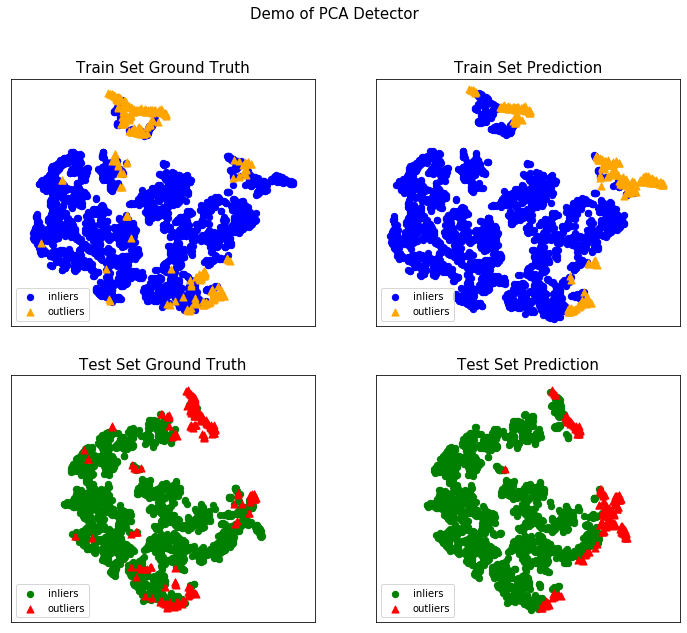

In [11]:
visualize(clf_name, X_train_tsne, y_train, X_test_tsne, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

## LOF

In [12]:
# train LOF detector
clf_name = 'LOF'
clf = LOF()
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

In [13]:
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
LOF ROC:0.774, precision @ rank n:0.3633

On Test Data:
LOF ROC:0.7522, precision @ rank n:0.3838


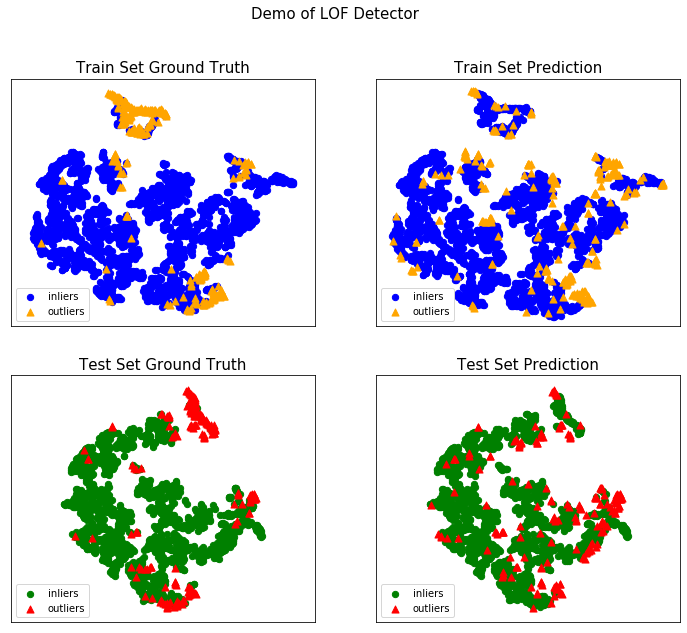

In [14]:
visualize(clf_name, X_train_tsne, y_train, X_test_tsne, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

对比KNN PCA LOF三种方法，在此数据集上用PCA分析利离群点的效果更好